In [6]:
import numpyro
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, DiscreteHMCGibbs

from jax import numpy as jnp
from jax import random

import numpy as np
import pandas as pd
# import seaborn as sns
import arviz as az

# from dfply import *
from siuba import _
import siuba as s

import pickle

%run -i 'model_helpers.py'
%run -i 'models.py'

In [7]:
df1 = load_query_avg_data_exp1() # see data_helpers.py
df1 = df1[~df1.querytype.str.contains('or')]
# df1 = df1[df1["condition"]!=2] # filter out "warm/snowy" as per paper
df1.head()


,ID,condition,querytype,querydetail,estimate
0,0,0,A,icy,0.503333
1,0,0,AandB,icy and frosty,0.616667
2,0,0,AandnotB,icy and not frosty,0.453333
3,0,0,AgB,icy given frosty,0.766667
4,0,0,AgnotB,icy given not frosty,0.340000


In [8]:
df2 = load_query_avg_data_exp2() # see data_helpers.py
df2 = df2[df2["condition"]!=2] # filter out "warm/snowy" as per paper
df2.head()


,ID,condition,querytype,querydetail,estimate
0,0,0,A,windy,0.733333
1,0,0,AandB,windy and cloudy,0.773333
2,0,0,AandnotB,windy and not cloudy,0.676667
3,0,0,AgB,windy given cloudy,0.816667
4,0,0,AgnotB,windy given not cloudy,0.600000


In [10]:
fits = dict()
fits["exp1"] = dict()
fits["exp2"] = dict()

fits["exp1"]["Relative Freq."] = pickle.load(open("local/exp1/az_data_rf.p", "rb"))
fits["exp1"]["Bayesian Sampler simple"] = pickle.load(open("local/exp1/az_data_bs_simple.p", "rb"))
fits["exp1"]["Bayesian Sampler complex"] = pickle.load(open("local/exp1/az_data_bs.p", "rb"))
fits["exp1"]["Bayesian Sampler simple MLM"] = pickle.load(open("local/exp1/az_data_bs_mlm_simple.p", "rb"))
fits["exp1"]["Bayesian Sampler complex MLM"] = pickle.load(open("local/exp1/az_data_bs_mlm.p", "rb"))
fits["exp1"]["PT+N complex"] = pickle.load(open("local/exp1/az_data_ptn.p", "rb"))
fits["exp1"]["PT+N simple"] = pickle.load(open("local/exp1/az_data_ptn_simple.p", "rb"))
fits["exp1"]["PT+N complex MLM"] = pickle.load(open("local/exp1/az_data_ptn_mlm.p", "rb"))
fits["exp1"]["PT+N simple MLM"] = pickle.load(open("local/exp1/mcmc_ptn_mlm_simple.p", "rb"))
fits["exp1"]["Unrestricted BS MLM"] = pickle.load(open("local/exp1/az_data_ptn_mlm_simplecond.p", "rb"))

fits["exp2"]["Relative Freq."] = pickle.load(open("local/exp2/az_data_rf.p", "rb"))
fits["exp2"]["Bayesian Sampler simple"] = pickle.load(open("local/exp2/az_data_bs_simple.p", "rb"))
fits["exp2"]["Bayesian Sampler complex"] = pickle.load(open("local/exp2/az_data_bs.p", "rb"))
fits["exp2"]["Bayesian Sampler simple MLM"] = pickle.load(open("local/exp2/az_data_bs_mlm_simple.p", "rb"))
fits["exp2"]["Bayesian Sampler complex MLM"] = pickle.load(open("local/exp2/az_data_bs_mlm.p", "rb"))
fits["exp2"]["PT+N complex"] = pickle.load(open("local/exp2/az_data_ptn.p", "rb"))
fits["exp2"]["PT+N simple"] = pickle.load(open("local/exp2/az_data_ptn_simple.p", "rb"))
fits["exp2"]["PT+N complex MLM"] = pickle.load(open("local/exp2/az_data_ptn_mlm.p", "rb"))
fits["exp2"]["PT+N simple MLM"] = pickle.load(open("local/exp2/mcmc_ptn_mlm_simple.p", "rb"))
fits["exp2"]["Unrestricted BS MLM"] = pickle.load(open("local/exp2/az_data_ptn_mlm_simplecond.p", "rb"))

In [11]:
exp1_model_comparison = az.compare(fits["exp1"], scale="deviance", ic="loo")
exp2_model_comparison = az.compare(fits["exp2"], scale="deviance", ic="loo")

exp1_model_comparison = exp1_model_comparison >> s.mutate(Experiment = "Exp. 1", model = exp1_model_comparison.index)
exp2_model_comparison = exp2_model_comparison >> s.mutate(Experiment = "Exp. 2", model = exp2_model_comparison.index)

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very differen

/opt/conda/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: paper/plot_compare.png


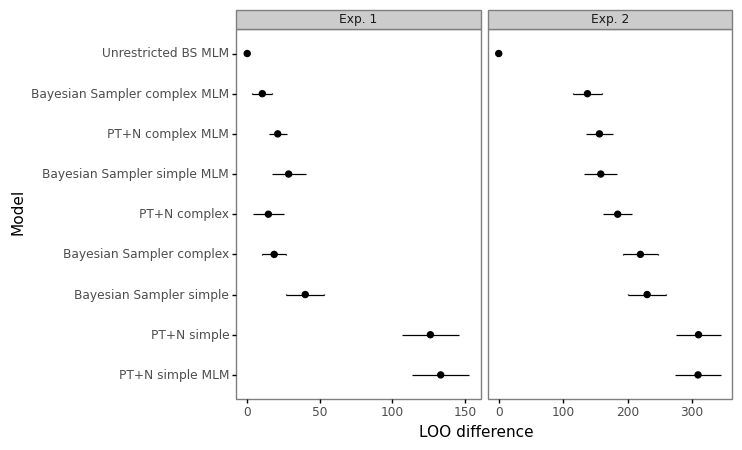

<ggplot: (8740404981751)>

In [15]:
from plotnine import *
import siuba as s
from siuba import _

model_comparison = exp1_model_comparison.append(exp2_model_comparison)

plt_compare = (
    model_comparison >>
    s.filter(_.model!="Relative Freq.") >>
    s.mutate(ul = _.d_loo + _.dse, ll = _.d_loo - _.dse) >>
    ggplot(aes(y="reorder(model, -d_loo)",  x= "d_loo", xmin="ll", xmax="ul")) +
    geom_point(size=2) +
    geom_errorbarh(height=.01, size=.5) +
    facet_wrap("Experiment", scales="free_x") +
    labs(x = "LOO difference", y = "Model") +
    theme_bw() +
    theme(panel_grid = element_blank())
)
plt_compare.save(filename="paper/plot_compare.png")
plt_compare

# Model parameters

## Experiment 1

In [16]:
model1 = fits["exp1"]["Unrestricted BS MLM"]

az.summary(
    model1,
    var_names = ["d_base_sd", "d_delta_sd"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,1.406,0.237,0.997,1.865,0.005,0.004,2170.0,3780.0,1.0
d_delta_sd,0.560,0.362,0.025,1.148,0.008,0.006,1772.0,4251.0,1.0


In [26]:
model1.posterior["d_prime_pop"] = model1.posterior.d_base_pop + np.exp(model1.posterior.d_delta_pop)
# az.plot_posterior(model1, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

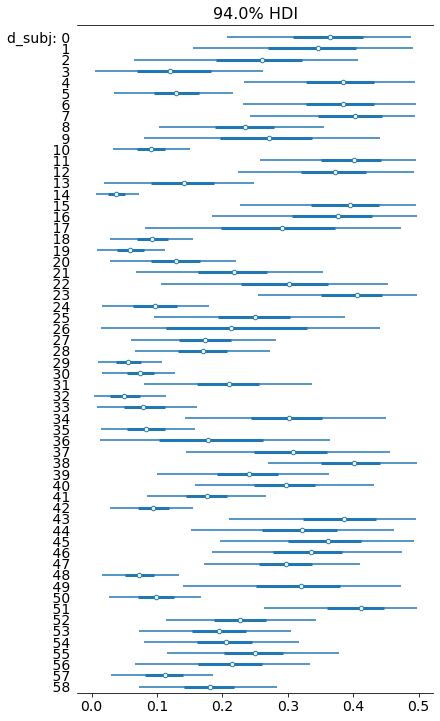

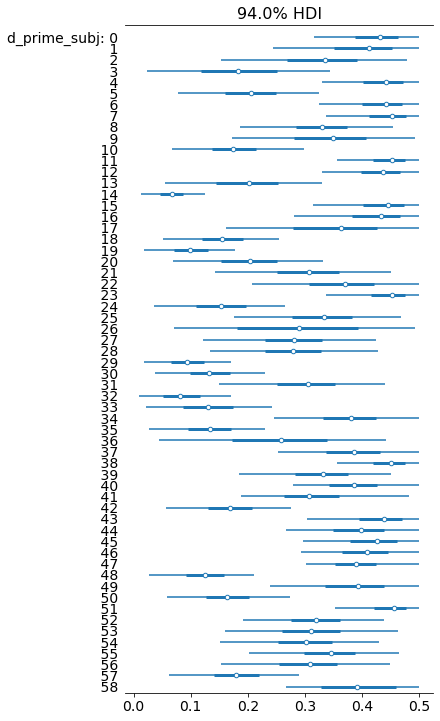

In [20]:
# plot them all
az.plot_forest(data=model1, var_names=["d_subj"], combined=True)
az.plot_forest(data=model1, var_names=["d_prime_subj"], combined=True)

In [21]:
# how many individual participant estimates are over .33 ?
print(np.sum(model1.posterior.stack(draws=("chain", "draw")).d_subj.mean(axis=1) > 1/3))
print(np.sum(model1.posterior.stack(draws=("chain", "draw")).d_prime_subj.mean(axis=1) > 1/3))

<xarray.DataArray 'd_subj' ()>
array(13)
<xarray.DataArray 'd_prime_subj' ()>
array(26)


## Experiment 2

/opt/conda/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: paper/plot_params.png


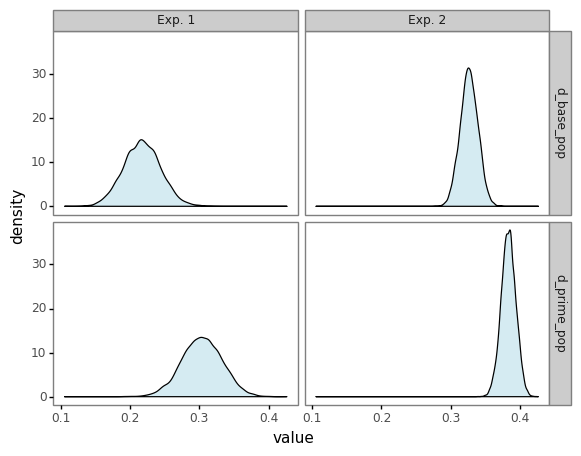

<ggplot: (8740404141626)>

In [27]:
model2 = fits["exp2"]["Unrestricted BS MLM"]
model2.posterior["d_prime_pop"] = model2.posterior.d_base_pop + np.exp(model2.posterior.d_delta_pop)
# az.plot_posterior(model2, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2)
param_posterior1 = model1.posterior.stack(draws=("chain", "draw"))[["d_base_pop", "d_prime_pop"]].to_dataframe()
param_posterior2 = model2.posterior.stack(draws=("chain", "draw"))[["d_base_pop", "d_prime_pop"]].to_dataframe()

param_posterior1 = param_posterior1 >> s.mutate(Experiment = "Exp. 1")
param_posterior2 = param_posterior2 >> s.mutate(Experiment = "Exp. 2")

plt_params = (
    param_posterior1.append(param_posterior2) >> 
    s.gather("term", "value", _.d_base_pop, _.d_prime_pop) >>
    s.mutate(value = _.value.transform(lambda x: np.exp(-np.logaddexp(0, -x))/2)) >>
    ggplot(aes(x="value")) +
    geom_density(fill="lightblue", alpha=.5) +
    facet_grid("term ~ Experiment") +
    theme_bw() +
    theme(aspect_ratio=.75) +
    theme(panel_grid = element_blank())
)
plt_params.save(filename="paper/plot_params.png")
plt_params

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

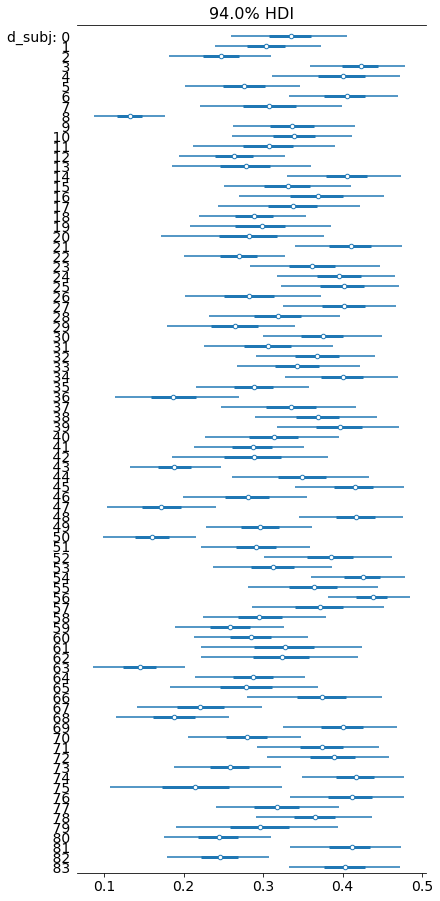

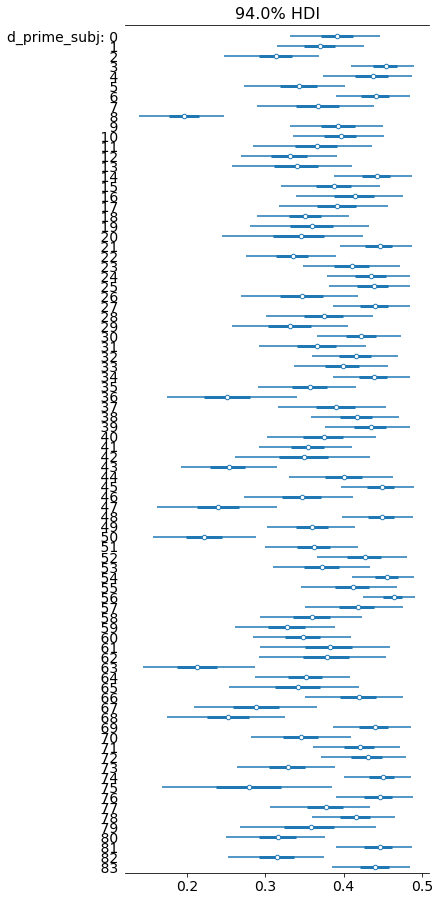

In [96]:
# plot them all
az.plot_forest(data=model2, var_names=["d_subj"], combined=True)
az.plot_forest(data=model2, var_names=["d_prime_subj"], combined=True)

Bayesian Sampler conditional response corr =  0.7187
Bayesian Sampler conditional query-level corr 0.9245


<AxesSubplot:xlabel='preds', ylabel='estimate'>

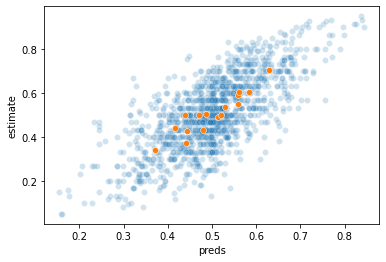

In [100]:
# zoom in on conditional trials

d = df2
d["preds"] = fits["exp2"]["Unrestricted BS MLM"].posterior_predictive.mean(dim=['chain', 'draw']).yhat
d = d[d.querytype.transform(is_cond).astype("bool")]
trial_df = (d
                .groupby(["querytype", "querydetail"])
                .agg({"preds":"mean", "estimate":"mean"}).reset_index()
               )

print("Bayesian Sampler conditional response corr = ", np.round(np.corrcoef(d.estimate, d.preds)[0,1],4))
sns.scatterplot(x = d.preds, y = d.estimate, alpha=.2)
print("Bayesian Sampler conditional query-level corr", np.round(np.corrcoef(trial_df.estimate, trial_df.preds)[0,1],4))
sns.scatterplot(x = trial_df.preds, y = trial_df.estimate)

PT+N conditional response corr =  0.6704
PT+N conditional query-level corr 0.8543


<AxesSubplot:xlabel='preds', ylabel='estimate'>

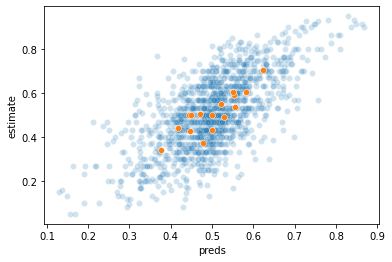

In [101]:
d = df2
d["preds"] = fits["exp2"]["PT+N complex MLM"].posterior_predictive.mean(dim=['chain', 'draw']).yhat
d = d[d.querytype.transform(is_cond).astype("bool")]

trial_df = (d
                .groupby(["querytype", "querydetail"])
                .agg({"preds":"mean", "estimate":"mean"}).reset_index()
               )

print("PT+N conditional response corr = ", np.round(np.corrcoef(d.estimate, d.preds)[0,1],4))
sns.scatterplot(x = d.preds, y = d.estimate, alpha=.2)
print("PT+N conditional query-level corr", np.round(np.corrcoef(trial_df.estimate, trial_df.preds)[0,1],4))
sns.scatterplot(x = trial_df.preds, y = trial_df.estimate)

# Create fit summary table

In [78]:
def response_level_r(orig_data, model):
    
    d = orig_data
    d["preds"] = model.posterior_predictive.mean(dim=['chain', 'draw']).yhat
    
    return np.round(np.corrcoef(d.estimate, d.preds)[0,1],3)
    
def trial_level_r(orig_data, model):
    
    d = orig_data
    d["preds"] = model.posterior_predictive.mean(dim=['chain', 'draw']).yhat

    trial_df = (d
                .groupby(["querytype", "querydetail"])
                .agg({"preds":"mean", "estimate":"mean"})
               )
    
    return np.round(np.corrcoef(trial_df.estimate, trial_df.preds)[0,1],3)
    
print(response_level_r(df1, fits["exp1"]["Unrestricted BS MLM"]))
print(trial_level_r(df1, fits["exp1"]["Unrestricted BS MLM"]))

0.725
0.821


In [86]:
exp1_corrs = pd.DataFrame({
    "model": fits["exp1"].keys(),
    "resp_r": [response_level_rsquare(df1, fits["exp1"][k]) for k in fits["exp1"].keys()],
    "trial_r": [trial_level_rsquare(df1, fits["exp1"][k]) for k in fits["exp1"].keys()],
    "Experiment": "Exp. 1"
     }
)

exp2_corrs = pd.DataFrame({
    "model": fits["exp2"].keys(),
    "resp_r": [response_level_rsquare(df2, fits["exp2"][k]) for k in fits["exp1"].keys()],
    "trial_r": [trial_level_rsquare(df2, fits["exp2"][k]) for k in fits["exp1"].keys()],
    "Experiment": "Exp. 2"
     }
)

full_model_compare = s.left_join(model_comparison, exp1_corrs.append(exp2_corrs), by=["model","Experiment"])

In [106]:
table_output = (
    full_model_compare >> 
    s.mutate(loo = np.round(_.loo,1), penalty = np.round(_.p_loo, 1)) >>
    s.select(_.Experiment, _.model, _.loo, _.penalty, _.resp_r, _.trial_r)
)

table_output

,Experiment,model,loo,penalty,resp_r,trial_r
0,Exp. 1,Unrestricted BS MLM,-1178.1,149.2,0.725,0.821
1,Exp. 1,Bayesian Sampler complex MLM,-1167.7,145.6,0.723,0.816
2,Exp. 1,PT+N complex,-1163.5,133.6,0.722,0.821
3,Exp. 1,Bayesian Sampler complex,-1159.5,149.3,0.723,0.815
4,Exp. 1,PT+N complex MLM,-1157.0,147.1,0.722,0.820
5,Exp. 1,Bayesian Sampler simple MLM,-1149.5,141.0,0.719,0.810
6,Exp. 1,Bayesian Sampler simple,-1138.1,146.8,0.718,0.806
7,Exp. 1,PT+N simple,-1051.8,132.6,0.695,0.793
8,Exp. 1,PT+N simple MLM,-1044.7,137.9,0.695,0.793
9,Exp. 1,Relative Freq.,-746.6,146.8,0.664,0.737


In [107]:
with open('paper/model-comparison-table.tex', 'w') as tf:
     tf.write(table_output.to_latex())

need to reconfigure this table, ideally with experiment as a horizontal grouping. not sure how to do that tho

In [161]:
with open('paper-rmd/model-comparison-table.csv', 'w') as tf:
     tf.write(table_output.to_csv())